Imports

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import mixed_precision
import pandas as pd
import seaborn as sns

2023-11-14 14:57:36.431756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 14:57:36.431808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 14:57:36.452238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 14:57:38.430772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

2023-11-14 15:00:11.470584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:00:11.657414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:00:11.657453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


1

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Sizes

In [4]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/PlantVillage",
                                                   shuffle=True,
                                                   image_size = (Image_size,Image_size),
                                                   batch_size = Batch_size)

Found 10687 files belonging to 9 classes.


2023-11-14 15:00:29.584940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:00:29.585099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:00:29.585128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:00:29.814591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:00:29.814632: I tensorflow/compile

Classes names and number

In [6]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
num_classes = len(class_names)
num_classes

9

In [8]:
def plot_label_distribution(dataset):
    labels = np.concatenate([batch[1] for batch in dataset], axis=0)
    df = pd.DataFrame(labels, columns = ['Labels'])
    df['Labels'] = df['Labels'].map({i:class_names[i] for i in range(num_classes)})
    plt.figure(figsize=[10,6])
    ax = sns.countplot(x=df['Labels'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

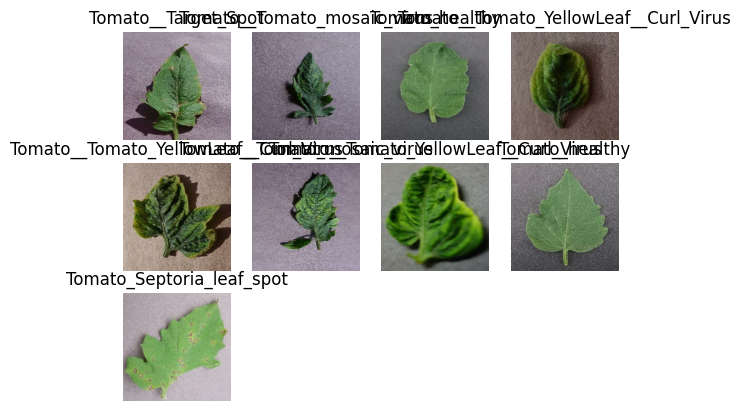

In [9]:
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
train_dataset = dataset.take(int(len(dataset)*0.8))
test_dataset = dataset.skip(len(train_dataset))
val_dataset = test_dataset.take(int(len(dataset)*0.1))
test_dataset = test_dataset.skip(len(val_dataset))

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1, test_split=0.1, shuffle = True, shuffle_size=100):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    train_dataset = ds.take(train_size)
    val_dataset=ds.skip(train_size).take(val_size)
    test_dataset=ds.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [12]:
train_dataset,test_dataset,val_dataset = get_dataset_partitions_tf(dataset)

In [13]:
train_dataset=train_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

/tmp/ipykernel_5270/2747945640.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


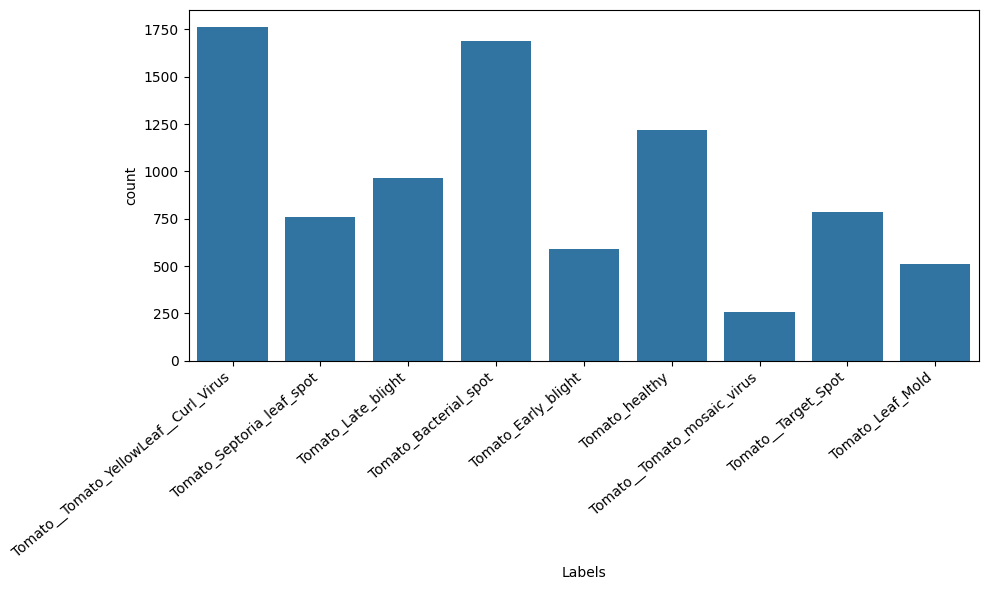

In [14]:
plot_label_distribution(train_dataset)

2023-11-14 15:01:18.321487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 1 of 100
2023-11-14 15:01:18.321630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
/tmp/ipykernel_5270/2747945640.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


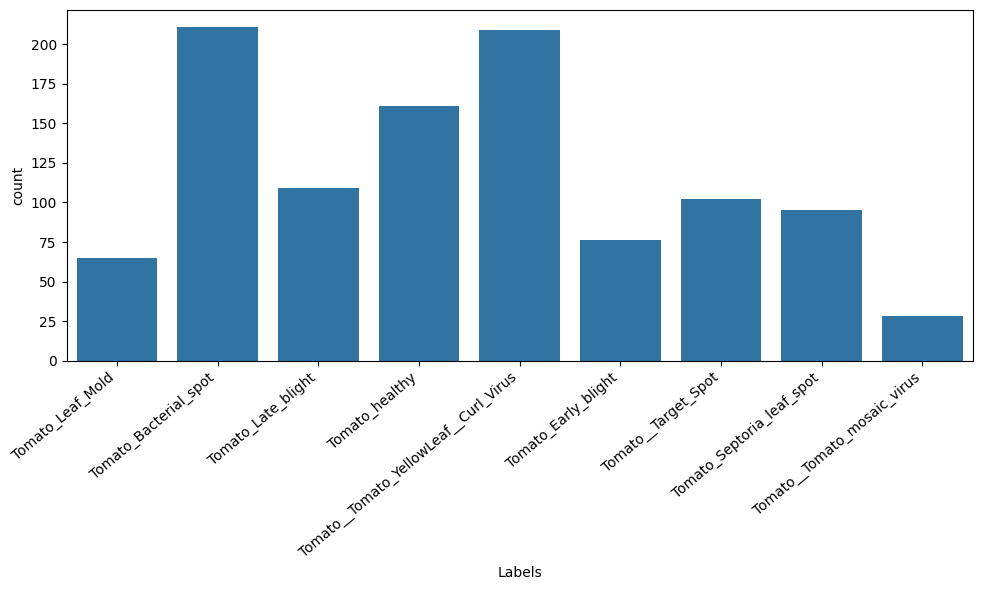

In [15]:
plot_label_distribution(test_dataset)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation=  resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
input_shape = (Batch_size,Image_size,Image_size, Channels)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3), padding="same", activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 63, 63, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 61, 61, 32)         

In [20]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=1e-7, min_delta=0.0004, mode='min')
early_stopping=EarlyStopping(monitor='val_loss', patience=5,start_from_epoch=3,restore_best_weights=True)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [22]:
history = model.fit(
    train_dataset,
    epochs=Epochs,
    batch_size  = Batch_size,
    callbacks = [early_stopping, reduce_lr],
    verbose = 1,
    validation_data=val_dataset
)

Epoch 1/50


2023-11-14 15:01:23.633558: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-11-14 15:01:23.721322: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-11-14 15:01:24.068481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-14 15:01:25.285441: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-14 15:01:26.028172: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilat

266/267 [============================>.] - ETA: 0s - loss: 2.0252 - accuracy: 0.4572

2023-11-14 15:01:46.548792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1 of 100
2023-11-14 15:01:46.548904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


267/267 [==============================] - 25s 67ms/step - loss: 2.0224 - accuracy: 0.4577 - val_loss: 1.2069 - val_accuracy: 0.5915 - lr: 1.0000e-04
Epoch 2/50
267/267 [==============================] - 6s 21ms/step - loss: 0.9365 - accuracy: 0.6819 - val_loss: 1.0505 - val_accuracy: 0.6486 - lr: 1.0000e-04
Epoch 3/50
267/267 [==============================] - 6s 21ms/step - loss: 0.7313 - accuracy: 0.7495 - val_loss: 1.2835 - val_accuracy: 0.6311 - lr: 1.0000e-04
Epoch 4/50
267/267 [==============================] - 6s 21ms/step - loss: 0.6370 - accuracy: 0.7831 - val_loss: 0.9370 - val_accuracy: 0.6983 - lr: 1.0000e-04
Epoch 5/50
267/267 [==============================] - 6s 21ms/step - loss: 0.5495 - accuracy: 0.8104 - val_loss: 1.0333 - val_accuracy: 0.6670 - lr: 1.0000e-04
Epoch 6/50
267/267 [==============================] - 6s 21ms/step - loss: 0.5185 - accuracy: 0.8210 - val_loss: 0.8628 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 7/50
267/267 [==============================

In [23]:
scores = model.evaluate(test_dataset)

 1/33 [..............................] - ETA: 0s - loss: 0.4319 - accuracy: 0.9062

33/33 [==============================] - 0s 11ms/step - loss: 0.7672 - accuracy: 0.7481


In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

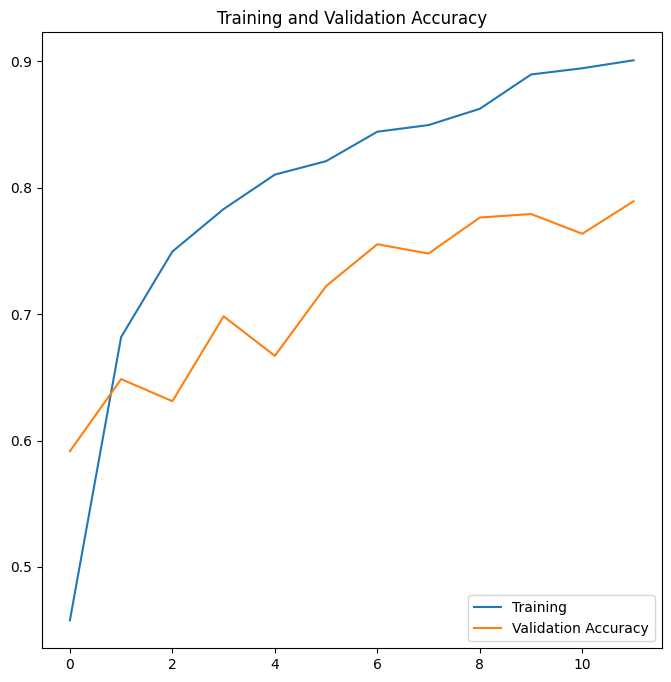

In [26]:
plt.figure(figsize=(8,8))
plt.plot(range(12), acc, label='Training')
plt.plot(range(12),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


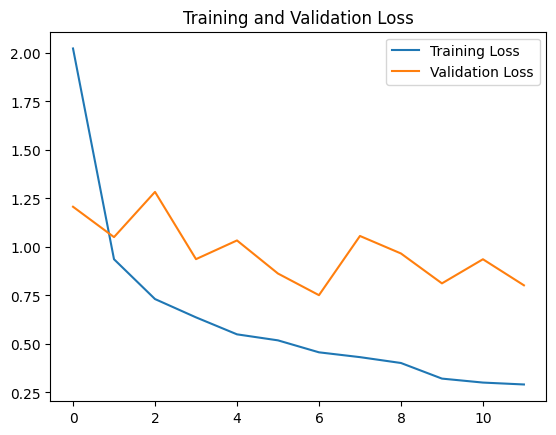

In [27]:
plt.plot(range(12), loss, label='Training Loss')
plt.plot(range(12),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.maxa(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
model_version=2
#model.save("Disease_model.h5")


In [29]:
import os
os.listdir()

['struktura_modelu.ipynb']

In [30]:
import keras_tuner
from keras.models import Sequential
from keras import Input

Using TensorFlow backend


In [ ]:


# def build_model(hp):
#     model = Sequential()
#     model.add(Input(shape=(Image_size, Image_size, 3)))
#     model.add(data_augmentation)
#     model.add(resize_and_rescale)
#     for i in range(hp.Int("num_layers", 3, 7, default=5)):
#         kernel1 = hp.Int(f"kernel _{i}alpha", min_value=1, max_value=5, step=2, default=1)
#         model.add(layers.Conv2D(hp.Int(f"units_{i}alpha", min_value=16, max_value=128, step=4, default=16), (kernel1,kernel1), padding="same", activation="relu"))
#         if hp.Boolean(f"Conv2D{i}beta"):
#             kernel2 = hp.Int(f"kernel_{i}beta", min_value=1, max_value=5, step=2, default=1)
#             model.add(layers.Conv2D(hp.Int(f"units_{i}beta", min_value=16, max_value=128, step=4, default=32), (kernel2,kernel2), padding="same", activation="relu"))
#         if hp.Boolean(f"Conv2D{i}gamma"):
#             kernel3 = hp.Int(f"kernel_{i}gamma", min_value=1, max_value=5, step=2, default=1)
#             model.add(layers.Conv2D(hp.Int(f"units_{i}gamma", min_value=16, max_value=128, step=4, default=64), (kernel3,kernel3), padding="same", activation="relu"))
#         if hp.Boolean(f"BatchNormalization{i}"):
#             model.add(layers.BatchNormalization())
#         model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Flatten()),
#     model.add(layers.Dense(hp.Int("dense1", min_value=32, max_value=1024, step=8, default=512), activation='relu'))
#     if hp.Boolean("Dropout1"):
#          model.add(layers.Dropout(hp.Float("Dropout1Rt", min_value=0.1, max_value=0.8, step=0.05, default=0.3)))
#     model.add(layers.Dense(hp.Int("dense2", min_value=16, max_value=1024, step=8), activation='relu'))
#     if hp.Boolean("Dropout2"):
#          model.add(layers.Dropout(hp.Float("Dropout2Rt", min_value=0.1, max_value=0.8, step=0.05, default=0.3)))
#     model.add(layers.Dense(n_classes, activation='softmax'))
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#                metrics=['accuracy'])
#     return model

In [ ]:

# build_model(keras_tuner.HyperParameters())
# tuner = keras_tuner.Hyperband(build_model,
# objective='val_accuracy',
# max_epochs=40,
# factor=3,
# directory='test1',
# project_name='vegetables'
# )
# early_stopping= EarlyStopping(monitor='val_loss', patience=10,start_from_epoch=3,restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=3, min_lr=1e-10, min_delta=0.0004, mode='min')
# tuner.search(train_dataset, epochs=50, validation_data=val_dataset, batch_size=Batch_size, use_multiprocessing = True, workers = 2, verbose=1, callbacks = [early_stopping, reduce_lr])
# models = tuner.get_best_models(num_models=5)
# model = models[0]
# for i in range(len(models)):
#     print(f"----------------------model{i}----------------------------")
#     print(models[i].summary())

Trial 80 Complete [00h 06m 24s]
val_accuracy: 0.7847285866737366

Best val_accuracy So Far: 0.9411223530769348
Total elapsed time: 00h 31m 07s
----------------------model0----------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      256       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                      

In [31]:
modelik = model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 32)       

In [32]:
from tensorflow.keras.layers import Dropout, BatchNormalization

In [33]:
def plot_confusion_matrix(actual, predicted, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted, num_classes=num_classes)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(15, 15)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of object recognition for ' + ds_type)
    ax.set_xlabel('Predicted Object')
    ax.set_ylabel('Actual Object')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)

In [35]:
def plot_acc_loss(history, model, test_data):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    accuracy, loss = model.evaluate(test_data)
    print(f"Number of missclassified images in test dataset: {int(accuracy * 3000)} of {3000}")
    return accuracy, loss

In [36]:
def calculate_classification_metrics(y_actual, y_pred):
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(class_names)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

        precision[class_names[i]] = tp[i] / (tp[i] + fp) # Precision 

        recall[class_names[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

In [37]:
model = Sequential([
   resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(64,(3,3), padding="same", activation = 'relu', input_shape = input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(100,kernel_size = (3,3), activation = 'relu'),
    layers.Conv2D(36,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(48,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(68, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(384,activation='relu'),
    layers.Dense(184,activation='relu') ,
    layers.Dense(n_classes,activation='softmax')
])

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [39]:
history = model.fit(
    train_dataset,
    epochs=100,
    batch_size  = 256,
    callbacks = [early_stopping, reduce_lr],
    verbose = 1,
    validation_data=val_dataset
)

Epoch 1/100


267/267 [==============================] - 23s 65ms/step - loss: 1.1178 - accuracy: 0.6143 - val_loss: 1.6041 - val_accuracy: 0.4931 - lr: 1.0000e-04
Epoch 2/100
267/267 [==============================] - 17s 62ms/step - loss: 0.6223 - accuracy: 0.7866 - val_loss: 1.3017 - val_accuracy: 0.6854 - lr: 1.0000e-04
Epoch 3/100
267/267 [==============================] - 16s 61ms/step - loss: 0.4618 - accuracy: 0.8336 - val_loss: 0.8878 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 4/100
267/267 [==============================] - 17s 62ms/step - loss: 0.3907 - accuracy: 0.8628 - val_loss: 1.1971 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 5/100
267/267 [==============================] - 16s 62ms/step - loss: 0.3249 - accuracy: 0.8821 - val_loss: 1.1884 - val_accuracy: 0.7148 - lr: 1.0000e-04
Epoch 6/100
267/267 [==============================] - 16s 62ms/step - loss: 0.2375 - accuracy: 0.9162 - val_loss: 0.7928 - val_accuracy: 0.8206 - lr: 1.5000e-05
Epoch 7/100
267/267 [===================

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

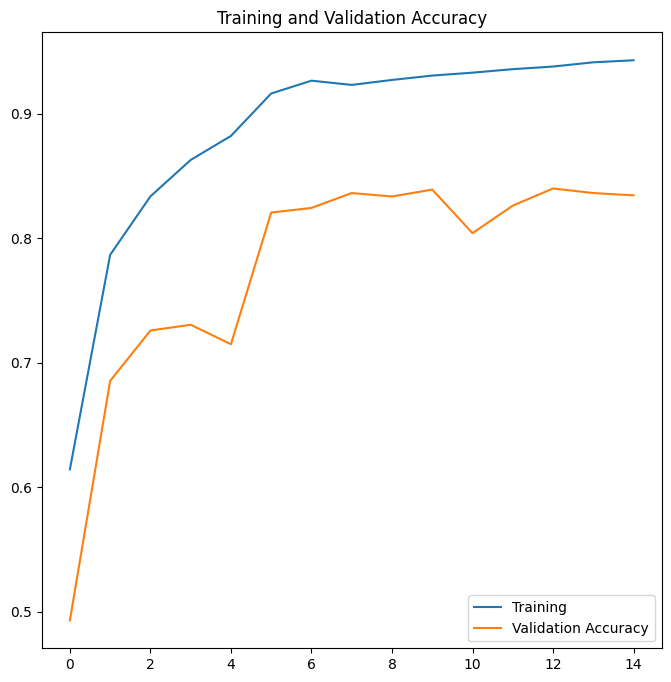

In [42]:
plt.figure(figsize=(8,8))
plt.plot(range(15), acc, label='Training')
plt.plot(range(15),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


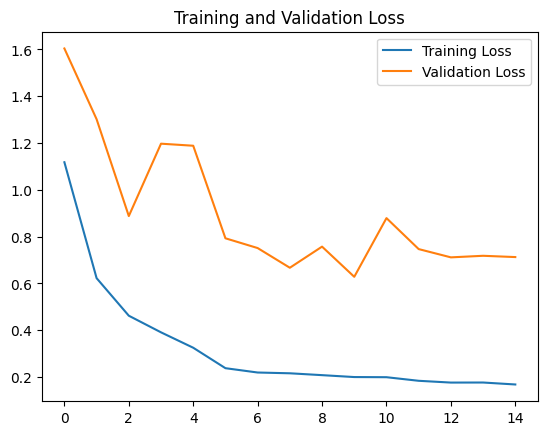

In [43]:
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
def get_actual_predicted_labels(dataset, model): 
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)
    return actual, predicted

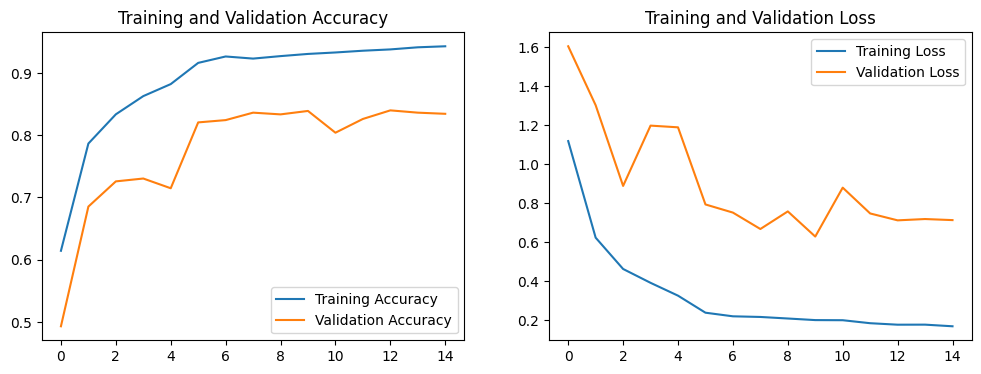

33/33 [==============================] - 1s 26ms/step - loss: 0.5642 - accuracy: 0.8532
Number of missclassified images in test dataset: 1692 of 3000


In [45]:
accuracy, loss = plot_acc_loss(history, model, test_dataset)

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=60)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [48]:
actual, predicted = get_actual_predicted_labels(test_dataset, model)

33/33 [==============================] - 1s 29ms/step


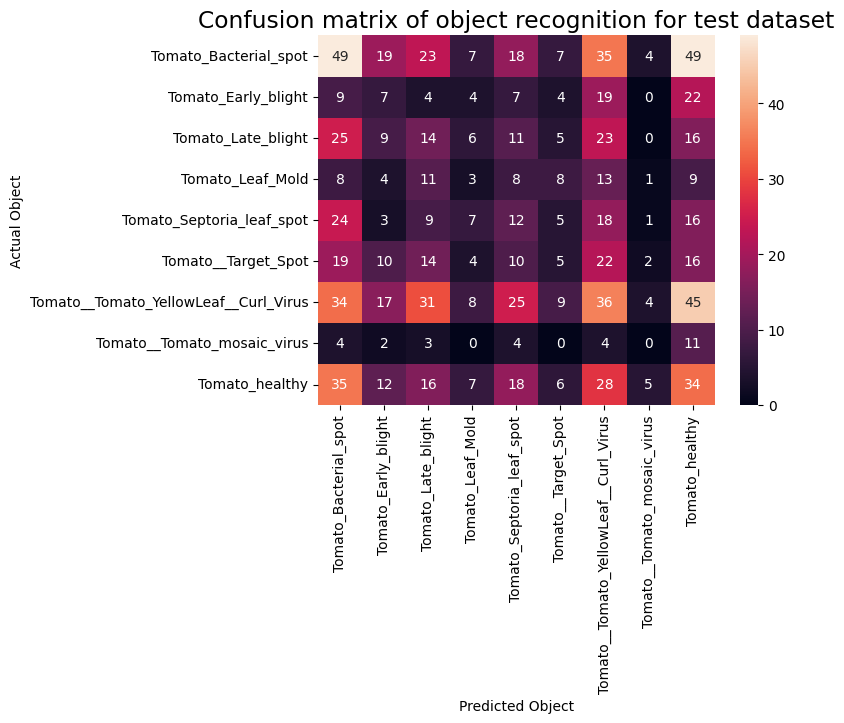

In [49]:
plot_confusion_matrix(actual, predicted, 'test dataset')

In [58]:
import webbrowser
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.maxa(predictions[0])), 2)
    
    if predicted_class == 'Tomato__Bacterial_spot':
        webbrowser.open('https://hort.extension.wisc.edu/articles/bacterial-spot-of-tomato/')
    elif predicted_class == 'Tomato__Early_blight':
        webbrowser.open('https://extension.umd.edu/resource/early-blight-tomatoes')
    elif predicted_class == 'Tomato__Late_blight':
        webbrowser.open('https://extension.wvu.edu/lawn-gardening-pests/plant-disease/fruit-vegetable-diseases/late-blight-tomatoes')
    elif predicted_class == 'Tomato__Leaf_Mold':
        webbrowser.open('https://www.lovethegarden.com/uk-en/garden-problem/tomato-leaf-mould')
    elif predicted_class == 'Tomato__Septoria_leaf_spot':
        webbrowser.open('https://www.missouribotanicalgarden.org/gardens-gardening/your-garden/help-for-the-home-gardener/advice-tips-resources/pests-and-problems/diseases/fungal-spots/septoria-leaf-spot-of-tomato')
    elif predicted_class == 'Tomato__Target_Spot':
        webbrowser.open('https://apps.lucidcentral.org/pppw_v10/text/web_full/entities/tomato_target_spot_163.htm')
    elif predicted_class == 'Tomato__Tomato_YellowLeaf__Curl_Virus':
        webbrowser.open('https://ipm.ifas.ufl.edu/agricultural_ipm/tylcv_home_mgmt.shtml')
    elif predicted_class == 'Tomato__Tomato_mosaic_virus':
        webbrowser.open('https://www.missouribotanicalgarden.org/gardens-gardening/your-garden/help-for-the-home-gardener/advice-tips-resources/pests-and-problems/diseases/viruses/tobacco-mosaic-virus')
    elif predicted_class == 'Tomato_healthy':
        print('Your TOmato is LOOKING GOOD :)')
        webbrowser.open('https://www.healthline.com/nutrition/foods/tomatoes')
           
    return predicted_class, confidence

In [59]:
model_version=2
model.save("Disease_model.h5")


/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
